In [2]:
using Revise, BeamPropagation, Distributions, StatsBase, StaticArrays, PhysicalConstants.CODATA2018, Plots, BenchmarkTools

In [4]:
const h = PlanckConstant.val
const ħ = h / 2π
const λ = @with_unit 626 "nm"
const k = 2π / λ
const m = @with_unit 57 "u"
const Δv = ħ * k / m
;

In [5]:
vz_μ = @with_unit 125 "m/s"
vz_σ = @with_unit 25 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 25 "m/s"
exit_radius = @with_unit 4 "mm"
;

In [10]:
const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(0, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0), 
    Normal(0, 0), 
    Normal(0, 0)
)
;

In [7]:
VBRs = Weights([
    0.9457,     # to 000
    0.0447,     # 100
    3.9e-3,     # 0200
    2.7e-3,     # 200
    9.9e-4,     # 0220
    11.3e-4,    # 0110
    3.9e-4,     # 1200
    1.5e-4,     # 300
    1.3e-4,     # 1220
    0.7e-4,     # 110 (only N=1, assuming roughly 2/3 to 1/3 rotational branching)
    0.4e-4,     # 110, N=2
    5.7e-5,     # 220
    4.3e-5      # other states
])

addressed = [
    true,   # to 000
    true,   # 100
    true,   # 0200
    true,   # 200
    true,   # 0220
    true,   # 0110
    true,   # 1200
    true,   # 300
    true,   # 1220
    true,   # 110
    false,   # 110, N=2
    false,   # 220
    false   # other states
]

transverse = [
    false,  # to 000
    false,  # 100
    false,  # 0200
    false,  # 200
    false,  # 0220
    false,  # 0110
    false,  # 1200
    false,  # 300
    true,   # 1220
    true,   # 110
    false,   # 110, N=2
    false,   # 220
    false   # other states
]
;

In [427]:
@inline function transverse_on(z)
    if 0.175 < z < 0.20     # 1st transverse region 17.5 - 20 cm after cell
        return true
    elseif 0.45 < z < 0.50  # 2nd transverse region 45 - 50 cm after cell
        return true
    elseif 0.56 < z < 0.61  # 2nd transverse region 56 - 61 cm after cell
        return true
    else
        return false
    end
end

@inline function random_unit3Dvector()
    θ = rand(Uniform(0, 2π))
    z = rand(Uniform(-1, 1))
    return @SVector [sqrt(1-z^2)*cos(θ), sqrt(1-z^2)*sin(θ), z]
end
;

In [428]:
const detect_rad  = @with_unit 0.5 "cm"
const detect_zloc = @with_unit 50 "cm"
const detect_zlen = @with_unit 0.5 "cm"
const dead_rad = @with_unit 1 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [429]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

@inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len)
@inline is_detectable(r) = sqrt(r[1]^2 + r[2]^2) < detect_rad && (detect_zloc + detect_zlen > r[3] > detect_zloc)
;

In [430]:
@inline function save(i, r, v, a, state, s)
    s.vzs[i] = v[3]
    s.detectable[i] = simple_prop(r, v) < detect_rad
    return nothing
end
;

@inline function f(i, r, v, a, state, dt, p, s)
    if is_detectable(r) && ~s.detectable[i]
        s.detectable[i] = true
    end
    if p.addressed[state] & (~p.transverse[state] | transverse_on(r[3]))
        state′ = sample(1:13, p.VBRs)
        v′ = @SVector [v[1], v[2], v[3] - Δv]
        v′ += Δv .* random_unit3Dvector()
        s.photons[i] += 1
    else
        state′ = state
        v′ = v
    end
    s.vzs[i] = v′[3]
    s.states[i] = state′
    return (state′, v′, a)
end
;

In [431]:
n = Int64(20e6)
scattering_rate = @with_unit 1.2 "MHz"
delete_every    = 15
dt              = 1 / scattering_rate
max_steps       = Int64(3.5e4)
;

In [432]:
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = ones(Int64, n)

p = @params (VBRs, transverse, addressed)
s = @params (vzs, photons, detectable, states)

@time s₀, sₜ = propagate!(n, r, v, a, f, save, discard, delete_every, dt, max_steps, p, s)
;

  2.862404 seconds (3.75 M allocations: 5.930 GiB, 22.28% gc time)


In [405]:
bright = [addressed[final_state] for final_state in sₜ.states]
;

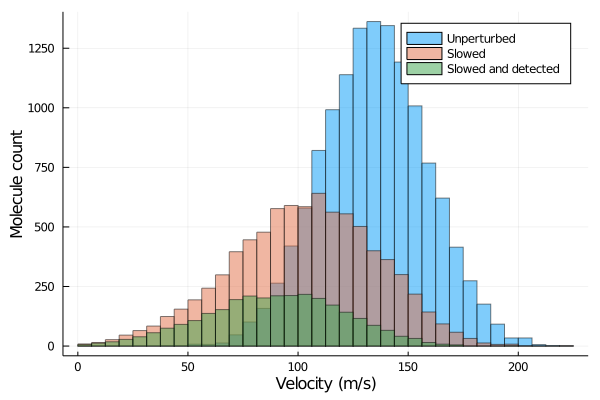

In [414]:
barhist(s₀.vzs[s₀.detectable], bins=0:25/4:225, alpha=0.5, xlim=[0,225], label="Unperturbed")
barhist!(sₜ.vzs[sₜ.detectable], bins=0:25/4:225, alpha=0.5, label="Slowed")
barhist!(sₜ.vzs[sₜ.detectable .& bright], bins=0:25/4:225, alpha=0.5, label="Slowed and detected")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

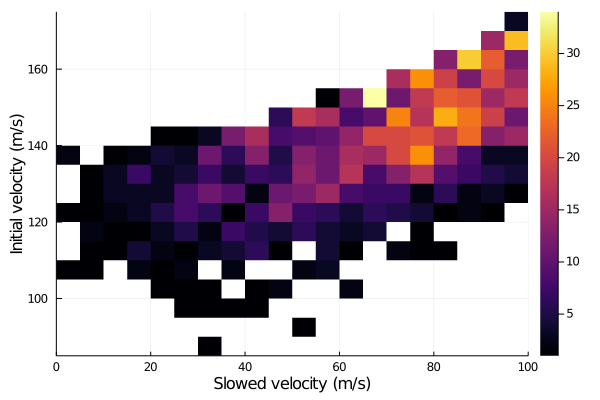

In [407]:
v_class = 0 .< sₜ.vzs .< 100
histogram2d(sₜ.vzs[sₜ.detectable .& bright.& v_class], s₀.vzs[sₜ.detectable .& bright .& v_class], bins=30)
ylabel!("Initial velocity (m/s)")
xlabel!("Slowed velocity (m/s)")

In [433]:
iters = 20

Rs = [0.6e6, 0.8e6, 1.0e6, 1.2e6, 1.4e6, 1.6e6, 1.8e6, 2.0e6, 2.2e6, 2.4e6]
data = zeros(iters, size(Rs,1))

for i in 1:iters
    for (j, R) in enumerate(Rs)
        dt = 1 / R

        vzs           = zeros(Float64, n)
        photons       = zeros(Int64, n)
        detectable    = zeros(Bool, n)
        states        = ones(Int64, n)
        s = @params (vzs, photons, detectable, states)

        @time s₀, sₜ = propagate!(n, r, v, a, f, save, discard, delete_every, dt, max_steps, p, s)

        bright = [addressed[final_state] for final_state in sₜ.states]
        perc_under_10ms = sum(abs.(sₜ.vzs[sₜ.detectable .& bright]) .< 10) / sum(s₀.detectable)
        data[i,j] = perc_under_10ms
    end
end

  2.299940 seconds (2.53 M allocations: 5.868 GiB, 29.59% gc time)
  2.504948 seconds (2.53 M allocations: 5.868 GiB, 27.54% gc time)
  2.603555 seconds (2.53 M allocations: 5.868 GiB, 26.34% gc time)
  2.714365 seconds (2.53 M allocations: 5.868 GiB, 24.72% gc time)
  2.893322 seconds (2.53 M allocations: 5.868 GiB, 23.85% gc time)
  2.913557 seconds (2.53 M allocations: 5.868 GiB, 23.41% gc time)
  2.988668 seconds (2.53 M allocations: 5.868 GiB, 22.67% gc time)
  3.045873 seconds (2.53 M allocations: 5.868 GiB, 22.10% gc time)
  3.099890 seconds (2.53 M allocations: 5.868 GiB, 21.70% gc time)
  3.176940 seconds (2.53 M allocations: 5.868 GiB, 21.89% gc time)
  2.287601 seconds (2.53 M allocations: 5.868 GiB, 29.48% gc time)
  2.460975 seconds (2.53 M allocations: 5.868 GiB, 27.65% gc time)
  2.586040 seconds (2.53 M allocations: 5.868 GiB, 25.93% gc time)
  2.699489 seconds (2.53 M allocations: 5.868 GiB, 24.61% gc time)
  2.861116 seconds (2.53 M allocations: 5.868 GiB, 23.12% gc t

  2.876985 seconds (2.53 M allocations: 5.868 GiB, 25.14% gc time)
  2.969537 seconds (2.53 M allocations: 5.868 GiB, 23.98% gc time)
  3.056345 seconds (2.53 M allocations: 5.868 GiB, 22.88% gc time)
  3.130811 seconds (2.53 M allocations: 5.868 GiB, 22.05% gc time)
  3.226926 seconds (2.53 M allocations: 5.868 GiB, 21.36% gc time)
  3.244187 seconds (2.53 M allocations: 5.868 GiB, 21.23% gc time)
  3.319900 seconds (2.53 M allocations: 5.868 GiB, 20.90% gc time)
  2.336698 seconds (2.53 M allocations: 5.868 GiB, 29.63% gc time)
  2.612839 seconds (2.53 M allocations: 5.868 GiB, 26.82% gc time)
  2.744730 seconds (2.53 M allocations: 5.868 GiB, 25.29% gc time)
  2.834968 seconds (2.53 M allocations: 5.868 GiB, 24.68% gc time)
  2.975386 seconds (2.53 M allocations: 5.868 GiB, 23.44% gc time)
  3.086972 seconds (2.53 M allocations: 5.868 GiB, 22.21% gc time)
  3.153494 seconds (2.53 M allocations: 5.868 GiB, 22.29% gc time)
  3.284328 seconds (2.53 M allocations: 5.868 GiB, 21.80% gc t

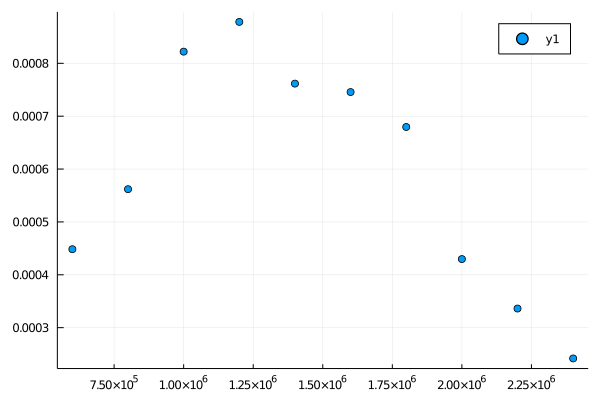

In [424]:
scatter(Rs, mean(data, dims=1)')

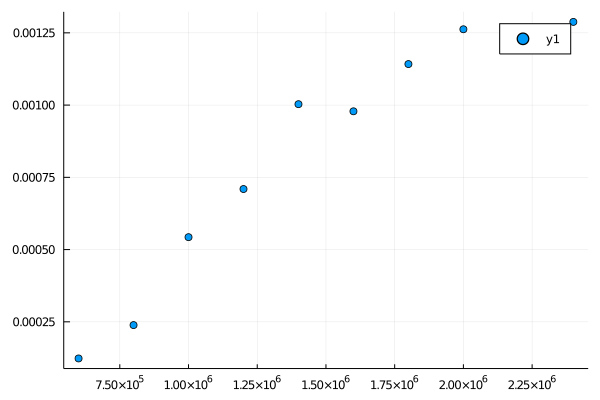

In [435]:
scatter(Rs, mean(data, dims=1)')